In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime
import networkx as nx
import math
from collections import Counter, OrderedDict
from scipy.stats import shapiro
from scipy.stats import ks_2samp
import scipy.stats as stats
from scipy.stats import lognorm
import statsmodels.api as sm
from scipy.stats import norm
import pylab
from scipy.stats import yeojohnson

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/tweetsConvereted2017_toxicPerspectiveScore.csv")

In [4]:
G = nx.read_edgelist('/content/gdrive/My Drive/users.edgelist')

In [5]:
groupDf = df[['user_id', 'Toxicity']]
groupDf2 = groupDf[['user_id', 'Toxicity']].astype({'user_id': str})
groupedDf = groupDf2.groupby(['user_id']).agg({'Toxicity': 'mean'}).reset_index()

In [6]:
users_list = list(groupedDf['user_id'].unique().astype(str))
G2 = G.subgraph(users_list)

In [7]:
user_toxicity = groupedDf.set_index('user_id')['Toxicity'].to_dict()

In [8]:
neighbor_toxicity = {}
for user in G2.nodes():
  neighbors = list(G2.neighbors(user))
  if user in neighbors:
      neighbors.remove(user)
  if len(neighbors) > 0:
      neighbor_toxicity[user] = groupedDf[groupedDf['user_id'].isin(neighbors)]['Toxicity'].mean()

In [9]:
x = [user_toxicity[user] for user in neighbor_toxicity.keys()]
y = list(neighbor_toxicity.values())

In [10]:
diff = [x[i] - y[i] for i in range(len(x))]
diff = [elem * 10 for elem in diff]
diff = [math.ceil(elem) if elem >= 0 else math.floor(elem) for elem in diff]
diff = [elem / 10 for elem in diff]

In [11]:
diff_counts = Counter(diff)
sorted_counts = OrderedDict(sorted(diff_counts.items()))

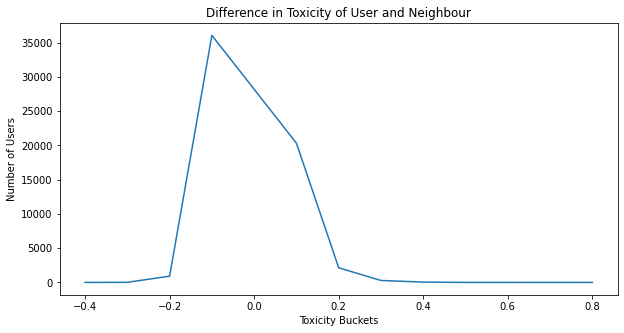

In [12]:
values = list(sorted_counts.keys())
counts = list(sorted_counts.values())

plt.figure(figsize=(10,5))
plt.plot(values, counts)
plt.xlabel('Toxicity Buckets')
plt.ylabel('Number of Users')
plt.title('Difference in Toxicity of User and Neighbour')
plt.show()

In [14]:
stat, p = shapiro(diff)

print("diff")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff
Shapiro-Wilk test statistic: 0.7124841213226318
p-value: 0.0
The sample is not normally distributed


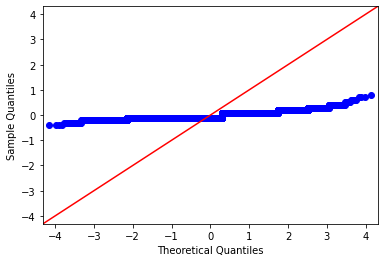

In [18]:
diff_qq = np.array(diff)
sm.qqplot(diff_qq, line='45')
pylab.show()

In [19]:
#box cox
shifted_diff = np.array(diff) - min(diff) + 1e-8
diff_boxcox, lambda_diff = stats.boxcox(shifted_diff)
print(lambda_diff)

0.22359171756190935


In [16]:
#yeo johnson
transformed_data, lambda_ = yeojohnson(diff)
print(lambda_)

In [25]:
#log transformation
shifted_diff_log = np.array(diff) - min(diff) + 1e-8
log_diff = np.log(shifted_diff_log)

In [36]:
#square root transformation
shifted_diff_sqrt = np.array(diff) - min(diff) + 1e-8
diff_sqrt = np.sqrt(shifted_diff_sqrt)

In [39]:
# Exponential Transformation
diff_exp = np.exp(diff)

In [41]:
stat, p = shapiro(diff_exp)

print("diff")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff
Shapiro-Wilk test statistic: 0.7085758447647095
p-value: 0.0
The sample is not normally distributed


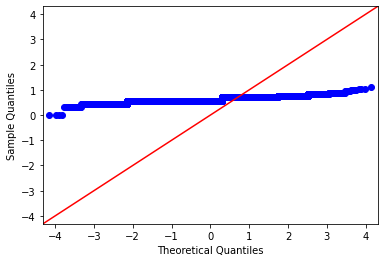

In [38]:
diff_qq_2 = np.array(diff_sqrt)
sm.qqplot(diff_qq_2, line='45')
pylab.show()

In [23]:
# https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/